In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, nquad, dblquad, simps
from scipy.special import ellipe, ellipk
from scipy.interpolate import lagrange, InterpolatedUnivariateSpline
from scipy.signal import savgol_filter
import math as math

## User input

In [2]:
# Gas:
# Conversion to linear scale was made in the notebook: grav_project/NGC_5005/Gas_from_mass_surface_density.ipynb
raddens = "../data/gasmsd_kpc_linear.txt"      # Gas density with 2 columns, units: KPC, MSUN/PC^2
maxkpc=11.0

# Parameters
z0 = 0.93
# Constants
G = 0.00000431158                   # Gravitational constant (KPC/MSUN*(KM/S)^2)  
CONSTANT = 2.0 * np.pi * G / 3.0

## Density profile, outputs: radii (array), densities (array), rcut (one #), delta (one #)

In [3]:
def DensityProfile(raddens=raddens):
    mudata = np.loadtxt(raddens)     
    xdinp, ydinp = mudata.T
    rcut = xdinp[len(xdinp)-1]               # rcut is the LAST radius value (?)
    delta = rcut - xdinp[len(xdinp)-2]       # difference between the last two radius values
    
    return xdinp, ydinp, rcut, delta

#defining these output values:
# Radius
xdinp = DensityProfile()[0]
# Density
ydinp = DensityProfile()[1]
# Cutoff radius
rcut = DensityProfile()[2]
# Cutoff length
delta = DensityProfile()[3]

## Interpolation

In [4]:
def interpd(x,y):
    #return lagrange(x,y)                # Lagrange interpolation didn't work well so I used Univariate Spline
    return InterpolatedUnivariateSpline(x,y,k=4)
    
# Calculate the density values at the sampling radii
spline_rhor = interpd(xdinp,ydinp)        # define the polynomial that's calculated

radii = np.arange(0.001,11,0.1)                # Sampling radii
## Partial derivative / Smoothing

In [5]:
#radii = np.linspace(0.001,maxkpc,100)                # Sampling radii
radii = np.arange(0.001,11,0.1)                # Sampling radii
print(radii)

# Partial derivative of rho(u,z) with respect to u
# Taking the derivative of the splined polynomial (radius and density values, rho(r) or rho(u))
drho_du = spline_rhor.derivative()

# Evaluating at given radii
drho_du_values = drho_du(radii)

# Smoothing: Savitzky-Golay filter: https://riptutorial.com/scipy/example/15878/using-a-savitzky-golay-filter
drho_du_smooth = savgol_filter(drho_du_values, 11, 5)  # window size 11, polynomial order 6

# Spline the smoothed derivative
spline_drhor = interpd(radii,drho_du_smooth)

[1.0000e-03 1.0100e-01 2.0100e-01 3.0100e-01 4.0100e-01 5.0100e-01
 6.0100e-01 7.0100e-01 8.0100e-01 9.0100e-01 1.0010e+00 1.1010e+00
 1.2010e+00 1.3010e+00 1.4010e+00 1.5010e+00 1.6010e+00 1.7010e+00
 1.8010e+00 1.9010e+00 2.0010e+00 2.1010e+00 2.2010e+00 2.3010e+00
 2.4010e+00 2.5010e+00 2.6010e+00 2.7010e+00 2.8010e+00 2.9010e+00
 3.0010e+00 3.1010e+00 3.2010e+00 3.3010e+00 3.4010e+00 3.5010e+00
 3.6010e+00 3.7010e+00 3.8010e+00 3.9010e+00 4.0010e+00 4.1010e+00
 4.2010e+00 4.3010e+00 4.4010e+00 4.5010e+00 4.6010e+00 4.7010e+00
 4.8010e+00 4.9010e+00 5.0010e+00 5.1010e+00 5.2010e+00 5.3010e+00
 5.4010e+00 5.5010e+00 5.6010e+00 5.7010e+00 5.8010e+00 5.9010e+00
 6.0010e+00 6.1010e+00 6.2010e+00 6.3010e+00 6.4010e+00 6.5010e+00
 6.6010e+00 6.7010e+00 6.8010e+00 6.9010e+00 7.0010e+00 7.1010e+00
 7.2010e+00 7.3010e+00 7.4010e+00 7.5010e+00 7.6010e+00 7.7010e+00
 7.8010e+00 7.9010e+00 8.0010e+00 8.1010e+00 8.2010e+00 8.3010e+00
 8.4010e+00 8.5010e+00 8.6010e+00 8.7010e+00 8.8010e+00 8.9010

C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


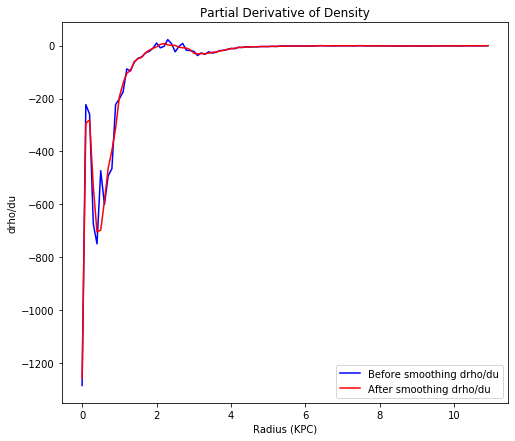

In [6]:
# Plot 
plt.figure(figsize=(8,7))
plt.plot(radii,drho_du_values, label="Before smoothing drho/du", c="blue")
plt.plot(radii,drho_du_smooth, label="After smoothing drho/du", c="red")
#plt.plot(radii,spline_drhor(radii), label="After smoothing and splining drho/du", c="purple")
plt.title("Partial Derivative of Density")
plt.xlabel("Radius (KPC)")
plt.ylabel("drho/du")
plt.legend()
plt.show()

## Functions

In [7]:
#from casertano http://articles.adsabs.harvard.edu/pdf/1983MNRAS.203..735C
# Casertano Eq 2
def drho_du(u,z,z0):
    return spline_drhor(u) * np.cosh(z / z0)**(-2)

print(drho_du(1,1,z0))

-73.01552084148702


In [8]:
# Casertano Eq 5
def px(r,u,z):
    x = (r**2 + u**2 + z**2)/(2*r*u)
    return x - np.sqrt((x**2)-1)

print(px(1,1,1))

0.3819660112501051


In [9]:
# Rotmod elliptic integral and p function (Casertano: Eq A.16)
def func(x,y,z):
    if( x == y ) & ( z == 0):
        r = 0
    elif( x == 0 ) | ( y == 0):
        r = 0
    else:
        xxx = (x*x + y*y + z*z) / (2.0 * x * y)
        
        # Added these 4 lines to fix the "dividing by zero" issue
        if xxx == 1.0:
            rrr = (xxx*xxx - 1.0) + 0.01
        else: 
            rrr = (xxx*xxx - 1.0)
            
        #rrr = (xxx*xxx - 1.0)
        ppp = 1.0 / (xxx + np.sqrt(rrr))
        fm = 1.0 - ppp*ppp
        el1 = (1.3862944 + fm * (0.1119723 + fm * 0.0725296)) - (0.5 + fm * (0.1213478 + fm * 0.0288729)) * np.log(fm)
        el2 = (1.0 + fm * ( 0.4630151 + fm * 0.1077812 ) ) - (fm * (0.2452727 + fm * 0.0412496)) * np.log(fm)
        r = ((1.0 - xxx * y/x) * el2 / (rrr) + (y/x - ppp) * el1 / np.sqrt(rrr)) / np.pi
        r *= np.sqrt(x / (y * ppp))
    return r

In [10]:
# Complete elliptic integral
def K_E(r,u,z):
    return ellipk(px(r,u,z)) - ellipe(px(r,u,z))

print(K_E(1,1,1))

0.35734399698214614


In [11]:
# Casertano eq 4, simplified
def integrand(r,u,z,z0,G):
    return (8 * G) * drho_du(u,z,z0) * K_E(r,u,z) / np.sqrt(u * r * px(r,u,z))

print(integrand(1,2,3,z0,G))

-2.4360377055043997e-07


## Integration

In [12]:
# Define minimum and maximum values of radius for integration
intmin = np.min(radii) #0 causes runtime issues but this gets very close
#intmax = 1e2 #np.max(radii) #Integration is from 0 to infinity but infinity gives overflow errors so we just pick the largest we can without causing errors
intmax = np.inf
print(intmin)
print(intmax)

0.001
inf


### Integration, using built-in python functions: scipy quad

In [13]:
# Inner integral, integral over z
integrand2 = lambda u,r,z0,G: u*quad(integrand, intmin, intmax, args=(r,u,z0,G))[0]
print(integrand2(2,1,z0,G))

# Calculate radial force
# Outer integral, integral over u
radialforce = lambda r,z0,G: quad(integrand2, intmin, intmax, args=(r,z0,G))[0]
radialforce = np.vectorize(radialforce)
print(radialforce(1,z0,G))

nan


C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which preve

nan


C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


### Integration, using ROTMOD functions

In [14]:
# Inner integral, integral over z
"""intzed computes the integral over Z that defines the kernel of the integral formula for the rotation velocity. 
This is done for an arbitrary vertical density profile, specified in the function denzed.
The interval of integration is divided into several subintervals, in each of which Simpson's rule is used. 
It is thus possible to have different steps in different regions of the interval of integration, 
and to compute the integral more accurately. An attempt has been made at optimizing the subdivision. 
It is still possible that the kernel is not accurate, especially when R is very close to U. 
It is NOT recommended that the programme is used with very small, but non-zero, values of the thickness. 
On the other hand, the situation with an infinitely thin disk is dealt with properly, the density profile in 
Z being then treated as a Dirac delta function."""
def intzed(r,u,z,z0):
    zeds = np.array([0.02, 0.50, 1.00, 3.00, 10.00])
    
    if (z0 != 0.0):
        n = 10
        
        if (np.abs(r - u) <= (0.2 * z0)):
            n = 200
        
        zne = 0.0
        res = 0.0
        i = 0
        while i < 5: 
            zol = zne
            zne = zeds[i] * z0
            step = (zne - zol) / n
            z = zol
            res += step * func(r,u,z) * drho_du(u,z,z0) / 3.0
            w = 4.0 / 3.0         
            j = 0.0
            while j < n:
                z += step
                res += step * func(r,u,z) * drho_du(u,z,z0) * w
                w = 2.0 - w
                j += 1
            res -= step * func(r,u,z) * drho_du(u,z,z0) / 3.0
            i += 1
    else:
        res = func(r,u,z0)
    return res

# Outer integral, integral over u
def interg(xd,yd,nd,r,rstart,z0,step,ndens):
    vsq = 0.0
    i = 1
    k = 0
    while k < ndens:
        if (k == 0 or k == (ndens - 1)):
            iw = 1
        else:
            iw = 4 - 2 * ((k + 1) % 2)
        
        x = rstart + step * k
        y = 0.0

        if (x < xd[nd-1]): 
            done = 0
            while (done == 0) & (i < (nd - 1)):
                #if i==1:
                    #print("            Checking xd...") #This if (xd...) loop is entered many times in quick succession; doesn't seem to be hanging so much as running too much. Not seeing the "increased i for the first time" as frequently as I would have expected, but this if statement IS completing quickly.
                if (xd[i-1] <= x) & (xd[i+1] >= x):
                    k1 = i - 1
                    while k1 <= (i + 1):
                        f = 1.0
                        k2 = i - 1
                        while k2 <= (i + 1):
                            if (k1 != k2):
                                f *= (x - xd[k2]) / (xd[k1] - xd[k2])
                            k2 += 1
                        y += f * yd[k1]
                        done = 1
                        k1 += 1
                else:
                    i += 1
            if (y > 0.0):
                res = intzed(r,x,y,z0)
                vsq += CONSTANT * res * y * step * iw
                if math.isnan(vsq):
                    print("vsq = {}".format(vsq))
        k += 1
    return vsq

In [15]:
velocs_rotmod = np.zeros(len(radii))
nradii = len(radii)
rings = xdinp
nring = len(rings)              # number of sampling radii
ntimes = len(xdinp)             # number of items
ndinp = len(ydinp)
naccur = 1
z1 = 0.58  #guess
h = 1      #guess

i = 0
j = 0

while i < nradii:
    r = radii[i]
    vsq = 0.0

    if i == 0:
        print("Loop variables set. Setting variable j...")
    
    while j < nring and rings[j] < r:
        j += 1

    if i == 0:
        print("Initial value of j set to "+str(j)+". Setting additional variables...")
    
    skip = rings[j] != r
    #z1 = z0
    
    r1 = r - 3.0 * z1
    if r1 < 0.0:
        r1 = 0.0
    
    r2 = 0.0

    if r1 < (rcut + 2.0 * delta):
        r2 = r + (r - r1)
        ndens = 6 * ntimes + 1
        step = (r2 - r1) / (ndens - 1)
        rstart = r1
        vsq += interg(xdinp,ydinp,ndinp,r,rstart,z0,step,ndens)
        
        if r1 > 0.0:
            ndens = r1 * ntimes / h
            ndens = 2 * (ndens / 2) + 3       # multiplies and devides by 2, it's unnecessary
            step = r1 / (ndens - 1)
            rstart = 0.0
            vsq += interg(xdinp,ydinp,ndinp,r,rstart,z0,step,ndens)
    
    if r2 < (rcut + 2.0 * delta):
        ndens = (rcut + 2.0 * delta - r2) * ntimes / h
        ndens = 2 * (ndens / 2) + 3
        step = (rcut + 2.0 * delta - r2) / (ndens - 1)
        rstart = r2
        vsq += interg(xdinp,ydinp,ndinp,r,rstart,z0,step,ndens)
    
    if vsq < 0.0:
        #velocs_rotmod[i] = (-np.sqrt(-vsq))
        velocs_rotmod[i] = (np.sqrt(-vsq))
    else:
        velocs_rotmod[i] = (np.sqrt(vsq))
    i += 1

Loop variables set. Setting variable j...
Initial value of j set to 0. Setting additional variables...


### Integration, using built-in python functions: scipy simps

### Integration, using manual simpson's rule

## Velocity

In [16]:
#casertano eq 6:
velocs = (-radii*radialforce(radii,z0,G))**(0.5)

#velocs_smooth = savgol_filter(velocs, 11, 4)

C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in cosh
  after removing the cwd from sys.path.


## Comparison

In [17]:
# Gas
tracedgas = np.loadtxt("../NGC_5005/traced_data/ngc5005_gas.txt")
tracedgas_r, tracedgas_v = tracedgas.T
tracedgas_r = tracedgas_r[1:]
tracedgas_v = tracedgas_v[1:]

# Disk
traceddisk = np.loadtxt("../NGC_5005/traced_data/ngc5005_disk.txt")
traceddisk_r, traceddisk_v = traceddisk.T
traceddisk_r = traceddisk_r[1:]
traceddisk_v = traceddisk_v[1:]

## Plot

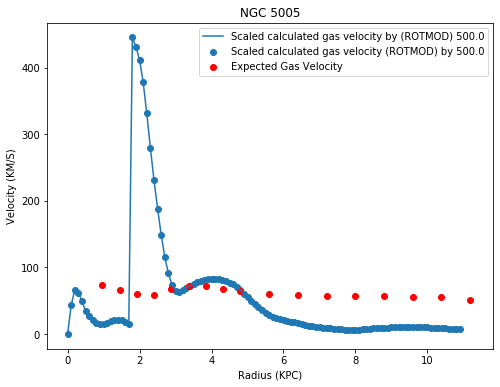

In [20]:
scale = 5e2
plt.figure(figsize=(8,6))             
#plt.scatter(radii, scale*velocs, linestyle='solid', label='Scaled calculated gas velocity (QUAD) by {}'.format(scale))
plt.scatter(radii, scale*velocs_rotmod, linestyle='solid', label='Scaled calculated gas velocity (ROTMOD) by {}'.format(scale))
plt.plot(radii, scale*velocs_rotmod, linestyle='solid', label='Scaled calculated gas velocity by (ROTMOD) {}'.format(scale))
#plt.plot(radii, 1e3*velocs_smooth, linestyle='solid', label='Smoothed Gas Velocity')
plt.scatter(tracedgas_r, tracedgas_v, label='Expected Gas Velocity', c='red')
plt.axis('tight');
plt.title('NGC 5005')
plt.xlabel('Radius (KPC)', fontsize=10)
plt.ylabel('Velocity (KM/S)', fontsize=10)
#plt.xlim(0,12)
plt.legend(fontsize=10)
plt.show()

In [19]:
print(velocs)
print(velocs_rotmod)

[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan       